Test instances: 32


/tmp/ipykernel_21924/2969120775.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)
/home/dan/anaconda3/envs/blitz/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


len bboxes: 3
boxes: [[ 10.130813  57.174446  23.21101   70.52572 ]
 [  8.550152 190.41469   21.956207 205.3782  ]
 [  8.110994 190.97314   23.068054 207.4766  ]]
boxes: [0.96996045 0.89756715 0.06789007]
box 0: [10 57 23 70]
class 0: DOT
box 1: [  8 190  21 205]
class 1: DOT


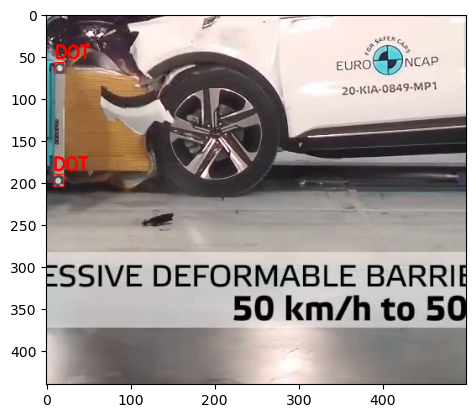

Image 2 done...
--------------------------------------------------
len bboxes: 4
boxes: [[413.9003    81.4024   435.9571   104.182915]
 [173.2897     0.       205.61047   28.402279]
 [164.69865  109.12119  193.65494  134.03946 ]
 [174.53415    0.       206.65234   28.115099]]
boxes: [0.9868134  0.56496555 0.5280996  0.07579356]
box 0: [413  81 435 104]
class 0: MXT90


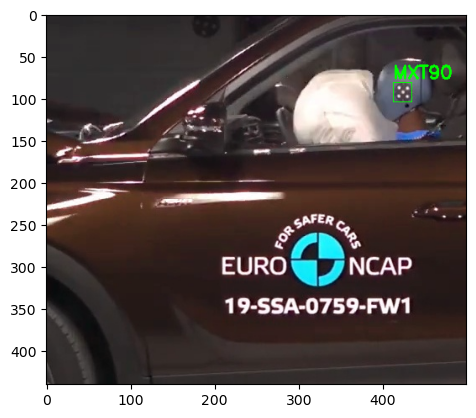

Image 1 done...
--------------------------------------------------


KeyboardInterrupt: 

In [1]:
import numpy as np
import cv2
import torch
import glob as glob
import models
import config
import utils
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torchvision
import mxtdot_dataset as MxtDotDataset
import os

savepoint_loc = config.SAVEPOINT_LOC

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

model = models.create_faster_rcnn_resnet50_fpn(config.NUM_CLASSES)
model.load_state_dict(models.load_custom_rpn_savestate(savepoint_loc,device))
model = model.to(device)
model.eval()

DIR_TEST = config.TEST_DIR_IMGS
test_images = glob.glob(f"{DIR_TEST}/*")
print(f"Test instances: {len(test_images)}")

detection_threshold = 0.8

for i in range(len(test_images)):
    image_name = test_images[i].split('/')[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float)
    # add batch dimension
    image = torch.unsqueeze(image, 0)

    with torch.no_grad():
        outputs = model(image)
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        print(f"len bboxes: {len(outputs[0]['boxes'])}")
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        print(f"boxes: {boxes}")
        print(f"boxes: {scores}")
        # filter boxes
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get predicted class names
        pred_classes = [config.CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # utils.visualize_sample(orig_image, target, classes)
        image = torch.squeeze(image,0)
        image = image.permute(1,2,0)
        img = image.cpu().numpy()
        
        for i,box in enumerate(boxes):
            print(f"box {i}: {box}")
            print(f"class {i}: {pred_classes[i]}")
            obj_class = pred_classes[i]

            if obj_class == "MXT90":
                color = (0,255,0)
            else:
                color = (255,0,0)

            cv2.rectangle(orig_image,(int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                        color, 1)

            cv2.putText(
                orig_image, obj_class, (int(box[0]), int(box[1]-5)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        plt.imshow(orig_image)
        plt.show()

    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')